In [1]:
# Import Data Science Libraries
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers, models
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3

from data_generation import prepare_data

BATCH_SIZE = 64
TARGET_SIZE = (224, 224)

In [2]:
train_df, val_df, test_df = prepare_data()

Train Shape:  (67708, 2)
Validation Shape:  (16927, 2)
Test Shape:  (5250, 2)


In [3]:
train_generator = ImageDataGenerator(
                        rescale=1./255,
                        rotation_range=30,
                        brightness_range=[0.7,1.3],
                        zoom_range=0.3,
                        width_shift_range=0.2, 
                        height_shift_range=0.2,
                        horizontal_flip=True)

test_generator = ImageDataGenerator(rescale=1./255)

# Generate Training images
train_images = train_generator.flow_from_dataframe(
                        dataframe=train_df,
                        x_col='Filepath',
                        y_col='Label',
                        target_size=TARGET_SIZE,  # all images will be resized to TARGET_SIZE
                        interpolation='nearest',
                        color_mode='rgb',
                        class_mode='categorical',
                        classes=list(train_df['Label'].unique()),
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        seed=175)

# Generate Validation images
val_images = test_generator.flow_from_dataframe(
                    dataframe=val_df,
                    x_col='Filepath',
                    y_col='Label',
                    target_size=TARGET_SIZE,  # all images will be resized to TARGET_SIZE
                    interpolation='nearest',
                    color_mode='rgb',
                    class_mode='categorical',
                    classes=list(train_df['Label'].unique()),
                    batch_size=BATCH_SIZE,
                    shuffle=True,
                    seed=42)

# Generate test images
test_images = test_generator.flow_from_dataframe(
                    dataframe=test_df,
                    x_col='Filepath',
                    y_col='Label',
                    target_size=TARGET_SIZE,  # all images will be resized to TARGET_SIZE
                    interpolation='nearest',
                    color_mode='rgb',
                    class_mode='categorical',
                    classes=list(train_df['Label'].unique()),
                    shuffle=False,
                    seed=42)

Found 67708 validated image filenames belonging to 525 classes.
Found 16927 validated image filenames belonging to 525 classes.
Found 5245 validated image filenames belonging to 525 classes.


In [4]:
base_model = InceptionV3(weights='inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                        include_top=False, 
                        input_shape=(TARGET_SIZE[0], TARGET_SIZE[1],3))
base_model.trainable = False

add_model = models.Sequential()
add_model.add(base_model)
add_model.add(layers.GlobalAveragePooling2D())
# add_model.add(layers.Dropout(0.2))
add_model.add(layers.Dense(1024, activation='relu'))
add_model.add(layers.BatchNormalization())
add_model.add(layers.Dense(525, activation='softmax'))

model = add_model
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
model.summary()

2024-04-15 00:18:29.288440: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-04-15 00:18:29.288463: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-04-15 00:18:29.288471: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-04-15 00:18:29.288491: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-15 00:18:29.288507: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ ?                      │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_94          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 21,802,784 (83.17 MB)

In [5]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./model/inceptionv3_tl.keras",
        save_best_only=True,
        monitor="val_loss"), 
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                      factor=0.2, 
                                      patience=3, 
                                      min_lr=1e-6),
    keras.callbacks.EarlyStopping(monitor='val_loss', 
                                  verbose=1,
                                  min_delta=0.05,
                                  patience=5)
                                      ]

history = model.fit(train_images, epochs=25, 
                    validation_data=val_images, callbacks=callbacks)
model.save_weights('./model/inceptionv3_tl.weights.h5') 

Epoch 1/25


2024-04-15 00:18:32.750772: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
/Users/akhil/Documents/NEU DAE/Spring24/NeuralNets/Project/bird_image_classifier/nndl_env/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1058/1058 ━━━━━━━━━━━━━━━━━━━━ 462s 431ms/step - accuracy: 0.3809 - loss: 2.9442 - val_accuracy: 0.6588 - val_loss: 1.3315 - learning_rate: 0.0010
Epoch 2/25
1058/1058 ━━━━━━━━━━━━━━━━━━━━ 465s 436ms/step - accuracy: 0.6496 - loss: 1.3932 - val_accuracy: 0.6991 - val_loss: 1.1581 - learning_rate: 0.0010
Epoch 3/25
1058/1058 ━━━━━━━━━━━━━━━━━━━━ 464s 435ms/step - accuracy: 0.6872 - loss: 1.2221 - val_accuracy: 0.7482 - val_loss: 0.9791 - learning_rate: 0.0010
Epoch 4/25
1058/1058 ━━━━━━━━━━━━━━━━━━━━ 463s 435ms/step - accuracy: 0.7121 - loss: 1.1028 - val_accuracy: 0.7359 - val_loss: 1.0121 - learning_rate: 0.0010
Epoch 5/25
1058/1058 ━━━━━━━━━━━━━━━━━━━━ 455s 427ms/step - accuracy: 0.7254 - loss: 1.0433 - val_accuracy: 0.7581 - val_loss: 0.9305 - learning_rate: 0.0010
Epoch 6/25
1058/1058 ━━━━━━━━━━━━━━━━━━━━ 463s 435ms/step - accuracy: 0.7379 - loss: 0.9906 - val_accuracy: 0.7597 - val_loss: 0.9055 - learning_rate: 0.0010
Epoch 7/25
1058/1058 ━━━━━━━━━━━━━━━━━━━━ 470s 441ms/step - acc

In [6]:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

0 input_layer
1 conv2d
2 batch_normalization
3 activation
4 conv2d_1
5 batch_normalization_1
6 activation_1
7 conv2d_2
8 batch_normalization_2
9 activation_2
10 max_pooling2d
11 conv2d_3
12 batch_normalization_3
13 activation_3
14 conv2d_4
15 batch_normalization_4
16 activation_4
17 max_pooling2d_1
18 conv2d_8
19 batch_normalization_8
20 activation_8
21 conv2d_6
22 conv2d_9
23 batch_normalization_6
24 batch_normalization_9
25 activation_6
26 activation_9
27 average_pooling2d
28 conv2d_5
29 conv2d_7
30 conv2d_10
31 conv2d_11
32 batch_normalization_5
33 batch_normalization_7
34 batch_normalization_10
35 batch_normalization_11
36 activation_5
37 activation_7
38 activation_10
39 activation_11
40 mixed0
41 conv2d_15
42 batch_normalization_15
43 activation_15
44 conv2d_13
45 conv2d_16
46 batch_normalization_13
47 batch_normalization_16
48 activation_13
49 activation_16
50 average_pooling2d_1
51 conv2d_12
52 conv2d_14
53 conv2d_17
54 conv2d_18
55 batch_normalization_12
56 batch_normalization_

In [7]:
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [9]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./model/inceptionv3_tl_unfrozen.keras",
        save_best_only=True,
        monitor="val_loss"), 
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                      factor=0.2, 
                                      patience=3, 
                                      min_lr=1e-6),
    keras.callbacks.EarlyStopping(monitor='val_loss', 
                                  verbose=1,
                                  min_delta=0.05,
                                  patience=5)
                                      ]

history = model.fit(train_images, epochs=50, 
                    validation_data=val_images, callbacks=callbacks)
model.save_weights('./model/inceptionv3_tl_unfrozen.weights.h5') 

Epoch 1/50
1058/1058 ━━━━━━━━━━━━━━━━━━━━ 461s 433ms/step - accuracy: 0.7830 - loss: 0.7985 - val_accuracy: 0.8046 - val_loss: 0.7465 - learning_rate: 0.0010
Epoch 2/50
1058/1058 ━━━━━━━━━━━━━━━━━━━━ 452s 424ms/step - accuracy: 0.7832 - loss: 0.7970 - val_accuracy: 0.8046 - val_loss: 0.7465 - learning_rate: 0.0010
Epoch 3/50
1058/1058 ━━━━━━━━━━━━━━━━━━━━ 447s 419ms/step - accuracy: 0.7770 - loss: 0.8069 - val_accuracy: 0.8046 - val_loss: 0.7465 - learning_rate: 0.0010
Epoch 4/50
1058/1058 ━━━━━━━━━━━━━━━━━━━━ 444s 417ms/step - accuracy: 0.7815 - loss: 0.8096 - val_accuracy: 0.8046 - val_loss: 0.7465 - learning_rate: 0.0010
Epoch 5/50
1058/1058 ━━━━━━━━━━━━━━━━━━━━ 444s 417ms/step - accuracy: 0.7801 - loss: 0.8161 - val_accuracy: 0.8046 - val_loss: 0.7465 - learning_rate: 2.0000e-04
Epoch 6/50
1058/1058 ━━━━━━━━━━━━━━━━━━━━ 447s 420ms/step - accuracy: 0.7824 - loss: 0.7929 - val_accuracy: 0.8046 - val_loss: 0.7465 - learning_rate: 2.0000e-04
Epoch 6: early stopping


In [10]:
model.evaluate(test_images)

/Users/akhil/Documents/NEU DAE/Spring24/NeuralNets/Project/bird_image_classifier/nndl_env/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


164/164 ━━━━━━━━━━━━━━━━━━━━ 27s 141ms/step - accuracy: 0.8750 - loss: 0.4451


[0.5000370144844055, 0.8577693104743958]

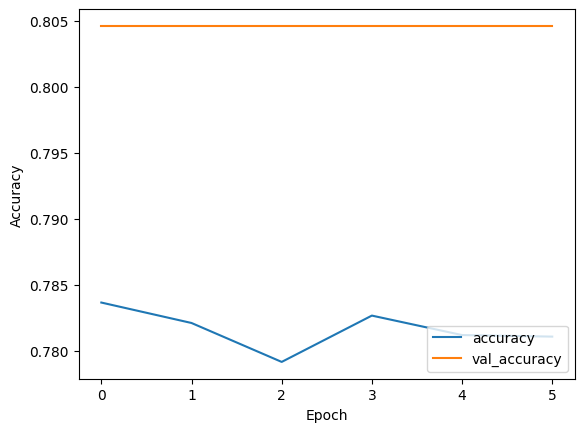

In [33]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.ylim([0.8, 1])
plt.legend(loc='lower right')

In [12]:
y_pred = model.predict(test_images)

164/164 ━━━━━━━━━━━━━━━━━━━━ 16s 95ms/step


In [30]:
y_pred.argmax(axis=1).shape

(5245,)

In [31]:
import numpy as np
np.array(test_images.classes).shape

(5245,)

In [32]:
from sklearn.metrics import f1_score
f1_score(np.array(test_images.classes), y_pred.argmax(axis=1), average='weighted')

0.8549186228159319